# Exploring Dataset

Goals: Open the data set, make some plots, gain some intuition for what your inputs for the models are going to be!


## 1. Load in the dataset

Just load the dataset in downloaded from Mendeley.

https://data.mendeley.com/datasets/pvn3xc3wy5/1

In [20]:
from __future__ import division, print_function
import h5py
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [21]:
d_gamma = h5py.File('../data/gamma.hdf5', 'r')
d_eplus = h5py.File('../data/eplus.hdf5', 'r')
d_piplus = h5py.File('../data/piplus.hdf5', 'r')

In [22]:
# Take a look at what variables are in the datasets 
for key in d_gamma:
    print(key)

energy
layer_0
layer_1
layer_2
overflow


The energy corresponds to the truth labels that we're going to try to learn for this regression task. 

Next: unpack these datasets!!

In [23]:
gamma_E    = d_gamma['energy'][:]
gamma_0    = d_gamma['layer_0'][:]
gamma_1    = d_gamma['layer_1'][:]
gamma_2    = d_gamma['layer_2'][:]
g_overflow = d_gamma['overflow'][:]

eplus_E    = d_eplus['energy'][:]
eplus_0    = d_eplus['layer_0'][:]
eplus_1    = d_eplus['layer_1'][:]
eplus_2    = d_eplus['layer_2'][:]
e_overflow = d_eplus['overflow'][:]

piplus_E   = d_piplus['energy'][:]
piplus_0   = d_piplus['layer_0'][:]
piplus_1   = d_piplus['layer_1'][:]
piplus_2   = d_piplus['layer_2'][:]
p_overflow = d_piplus['overflow'][:]

In [24]:
# Look at the first event
for i in range(5):
    
    print('\n\nEvent',i)
    print('Total Energy: {} GeV'.format(gamma_E[i]))
    
    imgs = [gamma_0[i], gamma_1[i], gamma_2[i]]
    
    E_layer = np.array([np.sum(img) for img in imgs])
    
    print('Layer 0: {} MeV'.format(E_layer[0]))
    print('Layer 1: {} MeV'.format(E_layer[1]))
    print('Layer 2: {} MeV'.format(E_layer[2]))
    print('Overflow: ',g_overflow[i])
    
    E_reco = np.sum(E_layer)/1000
    print('reco energy from layers {} GeV'.format(E_reco))
    sum_ovfl = np.sum(g_overflow[i])/1000
    print('overflow {} GeV'.format(sum_ovfl))
    
    print('reco + overflow {}'.format(E_reco+sum_ovfl))



Event 0
Total Energy: [ 68.92140509] GeV
Layer 0: 5725.28586987 MeV
Layer 1: 62348.5531234 MeV
Layer 2: 346.868688118 MeV
Overflow:  [  5.97469011  86.82075045   2.88631745]
reco energy from layers 68.4207076814 GeV
overflow 0.0956817580152 GeV
reco + overflow 68.5163894394


Event 1
Total Energy: [ 30.48531135] GeV
Layer 0: 9153.44425126 MeV
Layer 1: 21117.7822771 MeV
Layer 2: 23.7595637755 MeV
Overflow:  [  7.01464092  25.51877899   4.34652727]
reco energy from layers 30.2949860922 GeV
overflow 0.0368799471816 GeV
reco + overflow 30.3318660393


Event 2
Total Energy: [ 85.59280354] GeV
Layer 0: 10229.656556 MeV
Layer 1: 74766.532912 MeV
Layer 2: 97.0221261692 MeV
Overflow:  [ 16.2788195   76.01014154   1.513668  ]
reco energy from layers 85.0932115942 GeV
overflow 0.0938026290422 GeV
reco + overflow 85.1870142233


Event 3
Total Energy: [ 45.30479366] GeV
Layer 0: 10315.935894 MeV
Layer 1: 34719.1449343 MeV
Layer 2: 38.3877737482 MeV
Overflow:  [  6.25997022e+00   3.91373308e+01   

Something interesting to note: the difference between the reco energy and the overflow bins is the same order of magnitude as the the final difference between the reco and the truth energies.

## 2. Plot the distributions of $E_{truth}$ and $E_{reco}$ for each of the particle types, maybe the error??

In [25]:
real_images_gamma = [gamma_0, gamma_1, gamma_2]
real_images_eplus = [eplus_0, eplus_1, eplus_2]
real_images_piplus = [piplus_0, piplus_1, piplus_2]

In [26]:
def total_energy(d):
    '''
    Calculates the total energy for each event across all layers.
    Args:
    -----
    d: an h5py File with fields 'layer_2', 'layer_1', 'layer_0'
       that represent the 2d cell grids and the corresponding
       E depositons.
       
    Function taken from the CaloGAN repo 
    '''
    return d['layer_0'][:].sum(axis=(1, 2)) + d['layer_1'][:].sum(axis=(1, 2)) + d['layer_2'][:].sum(axis=(1, 2))


In [44]:
etot_orig_eplus = total_energy(d_eplus)
#etot_gen_eplus = total_energy(dgen_eplus)
etot_orig_gamma = total_energy(d_gamma)
#etot_gen_gamma = total_energy(dgen_gamma)
etot_orig_piplus = total_energy(d_piplus)
#etot_gen_piplus = total_energy(dgen_piplus)

In [71]:
gamma_df = pd.DataFrame()
eplus_df = pd.DataFrame()
piplus_df = pd.DataFrame()

dfs = [eplus_df, gamma_df, piplus_df]
reco_Es = [etot_orig_eplus, etot_orig_gamma, etot_orig_piplus] # rn in MeV
truth_Es = [eplus_E,gamma_E,piplus_E]

for df, etot_orig, Etruth in zip(dfs, reco_Es, truth_Es):

    df['Etruth'] = pd.Series([E[0] for E in Etruth])
    df['Ereco'] = pd.Series(etot_orig * 0.001)
    df['err'] = df['Etruth'] - df['Ereco']

In [72]:
gamma_df.head()

,Etruth,Ereco,err
0,68.921405,68.420708,0.500697
1,30.485311,30.294986,0.190325
2,85.592804,85.093212,0.499592
3,45.304794,45.073469,0.231325
4,7.545706,7.526048,0.019658


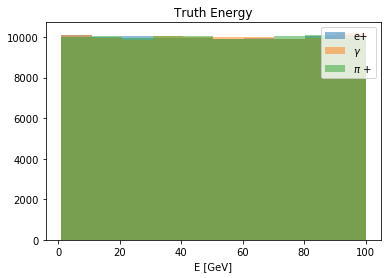

In [73]:
# Ok, everything's loaded in memory now... let's plot the histograms!!

plt.hist(eplus_df.Etruth, color='C0', label='e+', alpha=0.5)
plt.hist(gamma_df.Etruth, color='C1', label='$\gamma$', alpha=0.5)
plt.hist(piplus_df.Etruth, color='C2', label='$\pi$ +', alpha=0.5)
plt.xlabel('E [GeV]')
plt.title('Truth Energy')
plt.legend()
plt.show()

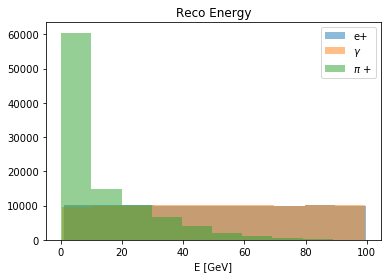

In [74]:

plt.hist(eplus_df.Ereco, color='C0', label='e+', alpha=0.5)
plt.hist(gamma_df.Ereco, color='C1', label='$\gamma$', alpha=0.5)
plt.hist(piplus_df.Ereco, color='C2', label='$\pi$ +', alpha=0.5)
plt.xlabel('E [GeV]')
plt.title('Reco Energy')
plt.legend()
plt.show()

In [75]:
etot_orig_eplus.shape

(100000,)

In [76]:
eplus_df.Etruth.shape

(100000,)

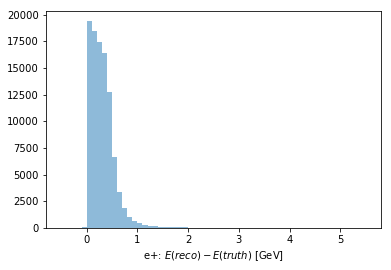

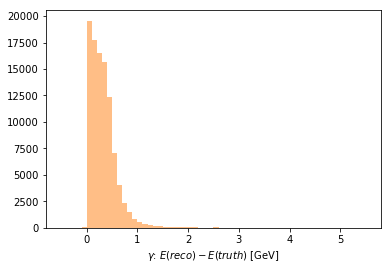

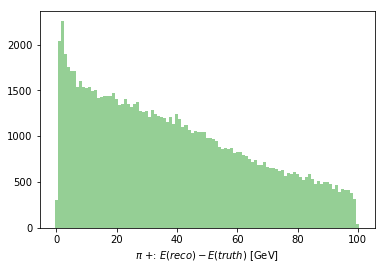

In [83]:
# Hmmm, is the goal to look at the energy resolution and find a correction that works for pions and well as
# e/gammas, OR also zoom in on the resolution of the e/gammas?

colors = ['C0','C1','C2']
labels = ['e+', '$\gamma$','$\pi$ +']
ranges = [(-0.5,5.5),(-0.5,5.5),(-0.5,100.5)]
Nbins = [60,60,101]
for c, df, label, myRange,N in zip(colors, dfs, labels, ranges, Nbins):

    plt.figure()
    plt.hist(df['err'], color=c, alpha=0.5, range=myRange, bins=N)
    plt.xlabel('{}: $E(reco) - E(truth)$ [GeV]'.format(label))

    
plt.show()

In [78]:
min(eplus_df.err),max(eplus_df.err)

(-0.0010219978200041169, 38.938677630555489)

In [79]:
min(gamma_df.err),max(gamma_df.err)

(-3.5527136788005009e-15, 74.000673820719243)

In [81]:
min(piplus_df.err),max(piplus_df.err)

(-0.11581469826671498, 99.694679055660103)

**Question**:
- Is this 1 GeV error for the $e^+$ / $\gamma$ significant or not?

**Note**:
- The pion errors are *huge* since pions aren't contained in the ECAL. BUT maybe we could build a classifier that is also able to distinguish between hadronic and EM showers?

**Another Question**:
- Is this what the EM and LC jets are trying to do?